In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm

import seaborn as sns
sns.color_palette("hls", 17)
import scipy.stats as st
import math

from pingouin import rcorr
import pingouin as pg
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, plot_roc_curve, roc_curve, auc, roc_auc_score,precision_recall_curve, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import MinMaxScaler

from sklearn import feature_selection #import chi2

import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

C:\Users\srandrad\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import sys
import os

from sys import platform
if platform == "darwin":
    sys.path.append(os.path.dirname(os.path.realpath(__file__)) + "/..")
    smart_nlp_path = ''
elif platform == "win32":
    sys.path.append('../')
    smart_nlp_path = os.getcwd()
    smart_nlp_path = "\\".join([smart_nlp_path.split("\\")[i] for i in range(0,len(smart_nlp_path.split("\\"))-1)]+["/"])

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
test_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_test.csv')).drop(["Unnamed: 0"], axis=1)
train_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_train.csv')).drop(["Unnamed: 0"], axis=1)
val_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_val.csv')).drop(["Unnamed: 0"], axis=1)

C:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3050: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
predictors = ["TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED",
              "ACRES",  "WF_FSR", "INJURIES", "FATALITIES", "EST_IM_COST_TO_DATE", "STR_DAMAGED",
              "STR_DESTROYED", "NEW_ACRES", "EVACUATION_IN_PROGRESS", 
              "NUM_REPORTS", "DAYS_BURING", 'Combined_Text', 'Incident_region_AICC', 
              'Incident_region_CA', 'Incident_region_EACC','Incident_region_GBCC', 'Incident_region_HICC', 
              'Incident_region_NRCC','Incident_region_NWCC', 'Incident_region_RMCC', 'Incident_region_SACC',
              'Incident_region_SWCC', 'INC_MGMT_ORG_ABBREV_1', 'INC_MGMT_ORG_ABBREV_2','INC_MGMT_ORG_ABBREV_3', 
              'INC_MGMT_ORG_ABBREV_4','INC_MGMT_ORG_ABBREV_5', 'INC_MGMT_ORG_ABBREV_B','INC_MGMT_ORG_ABBREV_C', 
              'INC_MGMT_ORG_ABBREV_D','INC_MGMT_ORG_ABBREV_E', 'INC_MGMT_ORG_ABBREV_F']
targets = ["Traffic","Command_Transitions","Evacuations", "Inaccurate_Mapping", "Aerial_Grounding", 
           "Resource_Issues", "Injuries", "Cultural_Resources","Livestock", "Law_Violations", "Military_Base", 
           "Infrastructure", "Extreme_Weather", "Ecological", "Hazardous_Terrain", "Floods", "Dry_Weather"]

# Prepare the Data

In [5]:
def remove_quote_marks(word_list):
    word_list = word_list.strip("[]").split(", ")
    word_list = [w.replace("'","") for w in word_list]
    word_list = " ".join(word_list)
    return word_list

In [6]:
dfs = [train_data, val_data, test_data]
for df in dfs:
    cleaned_combined_text = []
    for text in df['Combined_Text']:
        cleaned_text = remove_quote_marks(text)
        cleaned_combined_text.append(cleaned_text)
    df['Combined_Text'] = cleaned_combined_text

In [7]:
Xtrain = train_data['Combined_Text']; ytrain = train_data[targets]
Xval = val_data['Combined_Text']; yval = val_data[targets]
Xtest = test_data['Combined_Text']; ytest = test_data[targets]

### Power set label 
problem transformation to multiclass

<ipython-input-8-aeffb04db6be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytrain['powerlabel'] = ytrain.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)
<ipython-input-8-aeffb04db6be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yval['powerlabel'] = yval.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)
<ipython-input-8-aeffb04db6be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

<AxesSubplot:>

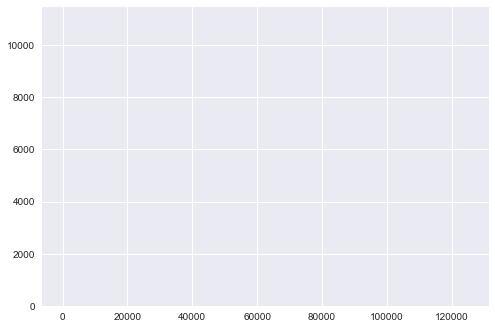

In [8]:
ytrain['powerlabel'] = ytrain.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)
yval['powerlabel'] = yval.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)
ytest['powerlabel'] = ytest.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)
ytrain['powerlabel'].hist(bins=np.unique(ytrain['powerlabel']))

## TF-iDF model

In [9]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2', max_features=10000)
vectorizer.fit(Xtrain)
Xtrain_vec = vectorizer.transform(Xtrain)
Xval_vec =  vectorizer.transform(Xval)
Xtest_vec= vectorizer.transform(Xtest)

In [10]:
#decreasing the number of features

In [11]:
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in targets:
    chi2, p = feature_selection.chi2(Xtrain_vec, ytrain[[cat]])
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [12]:
#for cat in y:
#    print("# {}:".format(cat))
#    print("  . selected features:",
#         len(dtf_features[dtf_features["y"]==cat]))
#    print("  . top features:", ",".join(
#        dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
#    print(" ")

In [13]:
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(Xtrain)
Xtrain_vec = vectorizer.transform(Xtrain)
Xval_vec =  vectorizer.transform(Xval)
Xtest_vec = vectorizer.transform(Xtest)

### Method: classifier chain
Note: classifier chains tend to perform worse on larget sets of targets. Also the performance is highly dependent on the order of the chain, so all orderings would ideally be tested.

In [14]:
classifiers = [LogisticRegression(max_iter=10000,multi_class='ovr'), RandomForestClassifier(random_state=1),
              KNeighborsClassifier(weights='distance'), MLPClassifier(random_state=1), RidgeClassifierCV()]
classifier_names = ['logistic regression', 'random forest', 'knn', 'MLP NN', 'Ridge']
hammingloss = []
for clf in classifiers:
    classifier = ClassifierChain(clf)
    classifier.fit(Xtrain_vec, ytrain[targets])
    # predict
    predictions = classifier.predict(Xtest_vec)
    hammingloss.append(hamming_loss(ytest[targets],predictions))

comparison = pd.DataFrame({"Base Estimator": classifier_names,
                           "hamming loss": hammingloss})
                    

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
comparison

,Base Estimator,hamming loss
0,logistic regression,0.056782
1,random forest,0.057298
2,knn,0.061850
3,MLP NN,0.063188
4,Ridge,0.059293


### Method: multioutput classifier

In [16]:
test_hamming_loss = []; train_hamming_loss = []
test_acc = []; train_acc = []
test_f1 = []; train_f1 = []
test_precision = []; train_precision = []
test_recall = []; train_recall = []

In [17]:
classifiers = [KNeighborsClassifier(weights='distance'),#SVC(kernel="linear", C=0.025),SVC(gamma=2, C=1),
               LinearSVC(multi_class='crammer_singer',max_iter=100000, class_weight='balanced'), DecisionTreeClassifier(),
               RandomForestClassifier(random_state=1, n_estimators=200),LogisticRegression(max_iter=10000,multi_class='multinomial'),
               MLPClassifier(alpha=1, max_iter=1000), RidgeClassifierCV(), AdaBoostClassifier()]
               #GaussianNB(), QuadraticDiscriminantAnalysis()]
total_names = ['Knn', #"Linear SVM", "RBF SVM",
                "Linear SVM", "Decision Tree", "Random Forest", 
                   "Logisitc Regression", 'MLP NN', 'Ridge', 'Adaboost']#, 'Gaussian NB', 'QDA']

In [18]:
for clf in tqdm(classifiers):
    classifier = clf#MultiOutputClassifier(clf)#, n_jobs=-1)
    classifier.fit(Xtrain_vec, ytrain['powerlabel'])
    predictions = classifier.predict(Xtest_vec)
    train_preds = classifier.predict(Xtrain_vec)
    test_acc.append(round(accuracy_score(ytest['powerlabel'],predictions),3)); train_acc.append(round(accuracy_score(ytrain['powerlabel'],train_preds),3))
    test_f1.append(round(f1_score(ytest['powerlabel'],predictions, average='macro',zero_division=0),3))
    train_f1.append(round(f1_score(ytrain['powerlabel'],train_preds, average='macro',zero_division=0),3))
    test_precision.append(round(precision_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
    train_precision.append(round(precision_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
    test_recall.append(round(recall_score(ytest['powerlabel'],predictions, average='macro', zero_division=0),3))
    train_recall.append(round(recall_score(ytrain['powerlabel'],train_preds, average='macro', zero_division=0),3))
    test_hamming_loss.append(round(hamming_loss(ytest['powerlabel'],predictions),3))
    train_hamming_loss.append(round(hamming_loss(ytrain['powerlabel'],train_preds),3))

 12%|██████████▌                                                                         | 1/8 [00:07<00:49,  7.13s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [10:43<00:00, 80.49s/it]


In [19]:
comparison = pd.DataFrame({"Model":total_names,
                           "train f1": train_f1, "test f1": test_f1,
                          "train accuracy":train_acc, "test accuracy": test_acc,
                          "train recall": train_recall, "test recall": test_recall,
                          "train precision": train_precision, "test precision": test_precision,
                          "train hamming loss": train_hamming_loss, "test hamming loss": test_hamming_loss})
comparison

,Model,train f1,test f1,train accuracy,test accuracy,train recall,test recall,train precision,test precision,train hamming loss,test hamming loss
0,Knn,0.985,0.006,0.991,0.532,0.982,0.007,0.991,0.012,0.009,0.468
1,Linear SVM,0.432,0.004,0.253,0.038,0.962,0.007,0.321,0.007,0.747,0.962
2,Decision Tree,0.985,0.008,0.991,0.448,0.982,0.008,0.991,0.009,0.009,0.552
3,Random Forest,0.986,0.006,0.991,0.538,0.984,0.007,0.990,0.009,0.009,0.462
4,Logisitc Regression,0.054,0.008,0.653,0.543,0.045,0.010,0.098,0.010,0.347,0.457
5,MLP NN,0.002,0.006,0.594,0.538,0.002,0.008,0.002,0.005,0.406,0.462
6,Ridge,0.172,0.008,0.682,0.539,0.157,0.009,0.260,0.007,0.318,0.461
7,Adaboost,0.005,0.007,0.596,0.538,0.006,0.010,0.005,0.006,0.404,0.462


### Method: One vs Rest classifier
note: this one performs better without the extreme over sampling -> maybe a simple over sampling approach is preferred here. Over fitting is definitely occuring

In [20]:
ytrain = ytrain[targets]
ytest = ytest[targets]
yval = yval[targets]

In [21]:
classifiers = [KNeighborsClassifier(weights='uniform', p=1),SVC(kernel="linear", C=0.025),SVC(gamma=2, C=1),
               #GaussianProcessClassifier(1.0 * RBF(1.0)),
               DecisionTreeClassifier(criterion='entropy', max_features='sqrt', class_weight=None, splitter='best'),
               RandomForestClassifier(criterion='entropy',max_features='auto', class_weight='balanced', n_estimators=100),
               LogisticRegression(max_iter=10000,multi_class='ovr',solver='sag'),
               MLPClassifier(alpha=1, max_iter=1000), RidgeClassifier(alpha=10), AdaBoostClassifier(learning_rate=1), 
               XGBClassifier(booster='gbtree', n_estimators=100, max_depth=4)
              ]#GaussianNB(), QuadraticDiscriminantAnalysis()]
classifier_name = ['Knn', "Linear SVM", "RBF SVM", #"Gaussian Process",
                   "Decision Tree", "Random Forest", 
                   "Logisitc Regression", 'MLP NN', 'Ridge', 'Adaboost', 'XGBoost' ]#,'Gaussian NB', 'QDA'
                  

In [22]:
test_hamming_loss = []; train_hamming_loss = []
test_acc = []; train_acc = []
test_f1 = []; train_f1 = []
test_precision = []; train_precision = []
test_recall = []; train_recall = []

In [23]:
for clf in tqdm(classifiers):
    classifier = OneVsRestClassifier(clf)#, n_jobs=-1)
    classifier.fit(Xtrain_vec, ytrain)
    predictions = classifier.predict(Xtest_vec)
    train_preds = classifier.predict(Xtrain_vec)
    test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
    test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
    train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
    test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
    train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
    test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
    train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
    test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
    train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [41:07<04:12, 252.48s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [41:24<00:00, 248.44s/it]


In [24]:
comparison = pd.DataFrame({"Model":classifier_name,
                          "train f1": train_f1, "test f1": test_f1,
                          "train accuracy":train_acc, "test accuracy": test_acc,
                          "train recall": train_recall, "test recall": test_recall,
                          "train precision": train_precision, "test precision": test_precision,
                          "train hamming loss": train_hamming_loss, "test hamming loss": test_hamming_loss})

In [25]:
comparison

,Model,train f1,test f1,train accuracy,test accuracy,train recall,test recall,train precision,test precision,train hamming loss,test hamming loss
0,Knn,0.624,0.007,0.743,0.533,0.496,0.003,0.857,0.100,0.027,0.062
1,Linear SVM,0.023,0.022,0.592,0.535,0.016,0.015,0.041,0.041,0.051,0.060
2,RBF SVM,0.837,0.046,0.896,0.546,0.770,0.035,0.922,0.111,0.008,0.055
3,Decision Tree,0.995,0.131,0.991,0.411,0.990,0.109,1.000,0.176,0.001,0.076
4,Random Forest,0.987,0.040,0.986,0.545,0.998,0.030,0.977,0.089,0.001,0.056
5,Logisitc Regression,0.328,0.092,0.631,0.536,0.223,0.065,0.786,0.258,0.038,0.055
6,MLP NN,0.050,0.044,0.597,0.543,0.041,0.034,0.095,0.091,0.047,0.056
7,Ridge,0.154,0.060,0.614,0.541,0.102,0.042,0.814,0.195,0.043,0.055
8,Adaboost,0.520,0.200,0.609,0.529,0.421,0.147,0.744,0.339,0.041,0.058
9,XGBoost,0.746,0.161,0.743,0.543,0.646,0.112,0.917,0.373,0.023,0.054


## Hyper parameter optomization

### KNN

In [28]:
params = {'n_neighbors': [1]+[i for i in range(5,55,5)],
         'weights':['uniform', 'distance'],
         'p':[1,2]}
best_params = {}

In [31]:
for param in params:
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in params[param]:
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(SVC(**test_params))#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

{'n_neighbors': 5, 'weights': 'uniform', 'p': 1}


### SVM

In [28]:
params = {'C': [i for i in range(1,11,1)],
         'class_weight':[None, "balanced"],
          'gamma': ['scale', 'auto',2],
         'break_ties':[True,False]}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(SVC(**test_params))#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### Decision Tree

In [32]:
params = {'criterion':['gini', 'entropy'],
         'max_features':['auto', 'sqrt', 'log2'],
         'class_weight':[None, "balanced"],
         'splitter':['best', 'random']}
best_params = {}

In [33]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(DecisionTreeClassifier(**test_params))#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:15<00:00, 63.84s/it]

{'criterion': 'entropy', 'max_features': 'sqrt', 'class_weight': None, 'splitter': 'best'}


### Random Forest

In [34]:
params = {'criterion':['gini', 'entropy'],
         'max_features':['auto', 'sqrt', 'log2'],
         'class_weight':[None, "balanced"],
         'n_estimators':[i for i in range(50, 550, 50)]}
best_params = {}

In [35]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(RandomForestClassifier(**test_params))#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [4:34:47<00:00, 4121.78s/it]

{'criterion': 'entropy', 'max_features': 'auto', 'class_weight': 'balanced', 'n_estimators': 100}


In [ ]:
rf = RandomForestClassifier(criterion='entropy',max_features='auto', class_weight='balanced', n_estimators=100)

### Logistic Regression

In [28]:
params = {'solver':['newton-cg', 'lbfgs', 'sag', 'saga'],
          'C': [i for i in range(1,11,1)],
         'class_weight':[None, "balanced"]}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(LogisticRegression(max_iter=10000,multi_class='ovr',**test_params))#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### MLP

In [28]:
params = {'alpha': [1*((10)**(i)) for i in range(-4,3,1)],
         'learning_rate':['constant', 'invscaling', 'adaptive'],
          'hidden_layer_sizes':[(50,), (50,50), (50,50,50), (100,), (100,100), (100,100,100)]}
best_params = {}

In [ ]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(MLPClassifier(max_iter=1000,**test_params))#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

### Ridge

In [13]:
params = {'alpha': [1*((10)**(i)) for i in range(-4,3,1)],
         'class_weight':[None, "balanced"]
         }
best_params = {}

In [14]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(RidgeClassifier(**test_params))#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:31<00:00, 15.85s/it]

{'alpha': 10, 'class_weight': None}


### XGBoost

In [27]:
params = {'max_depth':[None]+[i for i in range(3,25)]}#'booster': ['gbtree', 'gblinear', 'dart'], 'n_estimators': [i for i in range(100, 500, 25)]}
best_params = {'booster': 'gbtree','n_estimators':100}

In [28]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(XGBClassifier(**test_params))#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


  4%|███▌                                                                               | 1/23 [01:19<29:18, 79.92s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


  9%|███████▏                                                                           | 2/23 [02:09<24:46, 70.77s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 13%|██████████▊                                                                        | 3/23 [03:16<23:16, 69.80s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:15:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 17%|██████████████▍                                                                    | 4/23 [04:37<23:08, 73.09s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 22%|██████████████████                                                                 | 5/23 [06:05<23:16, 77.60s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 26%|█████████████████████▋                                                             | 6/23 [07:50<24:17, 85.76s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 30%|█████████████████████████▎                                                         | 7/23 [09:50<25:35, 95.99s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 35%|████████████████████████████▌                                                     | 8/23 [11:55<26:09, 104.62s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:24:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 39%|████████████████████████████████                                                  | 9/23 [14:09<26:31, 113.67s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:26:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 43%|███████████████████████████████████▏                                             | 10/23 [16:32<26:30, 122.34s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 48%|██████████████████████████████████████▋                                          | 11/23 [19:05<26:19, 131.65s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:31:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 52%|██████████████████████████████████████████▎                                      | 12/23 [21:49<25:52, 141.12s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:34:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:34:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:34:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 57%|█████████████████████████████████████████████▊                                   | 13/23 [24:41<25:06, 150.64s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:37:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 61%|█████████████████████████████████████████████████▎                               | 14/23 [27:45<24:05, 160.58s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:40:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 65%|████████████████████████████████████████████████████▊                            | 15/23 [30:55<22:35, 169.40s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:43:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:43:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:43:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 70%|████████████████████████████████████████████████████████▎                        | 16/23 [34:15<20:50, 178.59s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:46:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 74%|███████████████████████████████████████████████████████████▊                     | 17/23 [37:46<18:49, 188.25s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 78%|███████████████████████████████████████████████████████████████▍                 | 18/23 [41:27<16:29, 197.99s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 83%|██████████████████████████████████████████████████████████████████▉              | 19/23 [45:17<13:50, 207.56s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 87%|██████████████████████████████████████████████████████████████████████▍          | 20/23 [49:12<10:47, 215.99s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 91%|█████████████████████████████████████████████████████████████████████████▉       | 21/23 [53:19<07:30, 225.06s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 22/23 [57:34<03:54, 234.06s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [1:01:53<00:00, 3713.51s/it]

{'booster': 'gbtree', 'n_estimators': 100, 'max_depth': 4}


### Adaboost

In [19]:
params = {'base_estimator':[None, DecisionTreeClassifier(criterion='entropy', max_features='sqrt', class_weight=None, splitter='best')],
          'n_estimators':[i for i in range(50, 550, 50)],
          'learning_rate':[1*((10)**(i)) for i in range(-4,2,1)]
         }
best_params = {}

In [20]:
for param in tqdm(params):
    test_hamming_loss = []; train_hamming_loss = []
    test_acc = []; train_acc = []
    test_f1 = []; train_f1 = []
    test_precision = []; train_precision = []
    test_recall = []; train_recall = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        classifier = OneVsRestClassifier(AdaBoostClassifier(**test_params))#, n_jobs=-1)
        classifier.fit(Xtrain_vec, ytrain)
        predictions = classifier.predict(Xtest_vec)
        train_preds = classifier.predict(Xtrain_vec)
        test_acc.append(round(accuracy_score(ytest,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
        test_f1.append(round(f1_score(ytest,predictions, average='macro',zero_division=0),3))
        train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
        test_precision.append(round(precision_score(ytest,predictions, average='macro', zero_division=0),3))
        train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_recall.append(round(recall_score(ytest,predictions, average='macro', zero_division=0),3))
        train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
        test_hamming_loss.append(round(hamming_loss(ytest,predictions),3))
        train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
    best_params[param] = params[param][np.argmin(test_hamming_loss)]
print(best_params)

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:15:10<00:00, 1503.40s/it]

{'base_estimator': None, 'n_estimators': 50, 'learning_rate': 1}


In [ ]:
AdaBoostClassifier('learning_rate'=1)

## Method: LSTM Classifier

In [ ]:
def build_simple_lstm(history_window, num_features, num_neurons):
    
    input_layer = keras.layers.Input(shape=(history_window, num_features))
    
    rnn_layer = keras.layers.LSTM(num_neurons, activation='sigmoid')(input_layer)
    
    output = keras.layers.Dense(num_features)(rnn_layer)

    LSTM_model = keras.Model(input_layer, output)
    
    return LSTM_model

In [ ]:
## Plot confusion matrix

ml_cm = multilabel_confusion_matrix(ytest.to_numpy(), predicted)
i=0
for cm in ml_cm:
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix "+targets[i])
    plt.yticks(rotation=0)
    i+=1